# Sumário

- Importação e Download das Bibliotecas necessárias
- Download Imagens e Keypoints
- Análise Exploratória
- Separação do Conjunto da Categoria Bovinos
- Processamento de Filtros Aplicados
- Fluxo do Processamento em Diagrama
- Visualização Gráfica dos Resultados

# Importação e Download das Bibliotecas necessárias

In [279]:
import os  # Biblioteca para interação com o sistema operacional
import json  # Biblioteca para manipulação de arquivos JSON
import matplotlib.pyplot as plt  # Biblioteca para plotagem de gráficos
from PIL import Image, ImageDraw, ImageFilter, ImageChops, ImageEnhance  # Biblioteca Python Imaging Library (PIL) para processamento de imagens
import numpy as np  # Biblioteca para manipulação de arrays e matrizes
from google.colab import drive  # Biblioteca para acesso ao Google Drive
import pandas as pd  # Biblioteca para manipulação e análise de dados
import cv2  # OpenCV, uma biblioteca de visão computacional
from graphviz import Digraph  # Biblioteca para criação de gráficos

# Download Imagens e Keypoints

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
images_path = "/content/drive/MyDrive/images/images"
keypoint_path = "/content/drive/MyDrive/keypoints.json"

In [109]:
# Função simplificada para carregar todas as imagens do diretório usando Pillow
def load_all_images(images_path):
    images, image_files = [], []
    for img in os.listdir(images_path):
        if img.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
            image_file = os.path.join(images_path, img)
            image = Image.open(image_file).convert('RGB')
            images.append(np.array(image))
            image_files.append(image_file)
    return images, image_files

images, image_files = load_all_images(images_path)

# Função para carregar os keypoints do arquivo JSON
def load_keypoints(keypoint_path):
    with open(keypoint_path, 'r') as file:
        keypoints = json.load(file)
    return keypoints

# Carregar os keypoints
keypoints = load_keypoints(keypoint_path)

In [114]:
# Exibição dos keys do dicionário
keypoints.keys()

dict_keys(['images', 'annotations', 'categories', 'info'])

In [329]:
# Separação da chave annotations do dicionário
annotations = keypoints['annotations']

In [116]:
# Separação da chave categories do dicionário
categories = keypoints['categories']

In [117]:
# Transformação em DataFrame
categories_dataframe = pd.DataFrame(categories)

In [118]:
# Transformação em Dataframe
annotations_dataframe = pd.DataFrame(annotations)

In [119]:
# Visualização das 5 categorias
categories_dataframe

,supercategory,id,name,keypoints,skeleton
0,animal,1,dog,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."
1,animal,2,cat,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."
2,animal,3,sheep,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."
3,animal,4,horse,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."
4,animal,5,cow,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."


In [331]:
# Visualização de todas as mais de 4000 imagens com suas mais de 6000 instâncias
annotations_dataframe

,image_id,bbox,keypoints,num_keypoints,category_id
0,1,"[123, 115, 379, 275]","[[193, 216, 1], [160, 217, 1], [174, 261, 1], ...",20,1
1,2,"[25, 34, 419, 271]","[[330, 84, 1], [245, 91, 1], [290, 137, 1], [3...",20,3
2,3,"[54, 50, 285, 262]","[[275, 102, 1], [247, 105, 1], [269, 156, 1], ...",20,4
3,4,"[100, 96, 355, 324]","[[0, 0, 0], [327, 161, 1], [350, 192, 1], [333...",20,4
4,5,"[71, 252, 216, 314]","[[103, 269, 1], [86, 269, 1], [92, 284, 1], [1...",20,5
...,...,...,...,...,...
6112,4604,"[33, 63, 547, 559]","[[119, 140, 1], [0, 0, 0], [48, 183, 1], [158,...",20,3
6113,4605,"[119, 50, 729, 594]","[[656, 113, 1], [0, 0, 0], [580, 181, 1], [683...",20,3
6114,4606,"[105, 38, 565, 598]","[[250, 91, 1], [166, 91, 1], [214, 148, 1], [2...",20,3
6115,4607,"[65, 54, 263, 202]","[[245, 93, 1], [210, 94, 1], [232, 115, 1], [2...",20,3


# Análise Exploratória

É possível inferir com o gráfico que a maioria dos pixels dentre as imagens do dataset ocupam uma maior frequência na ponta direita do gráfico, ou seja, pixels de alta intensidade

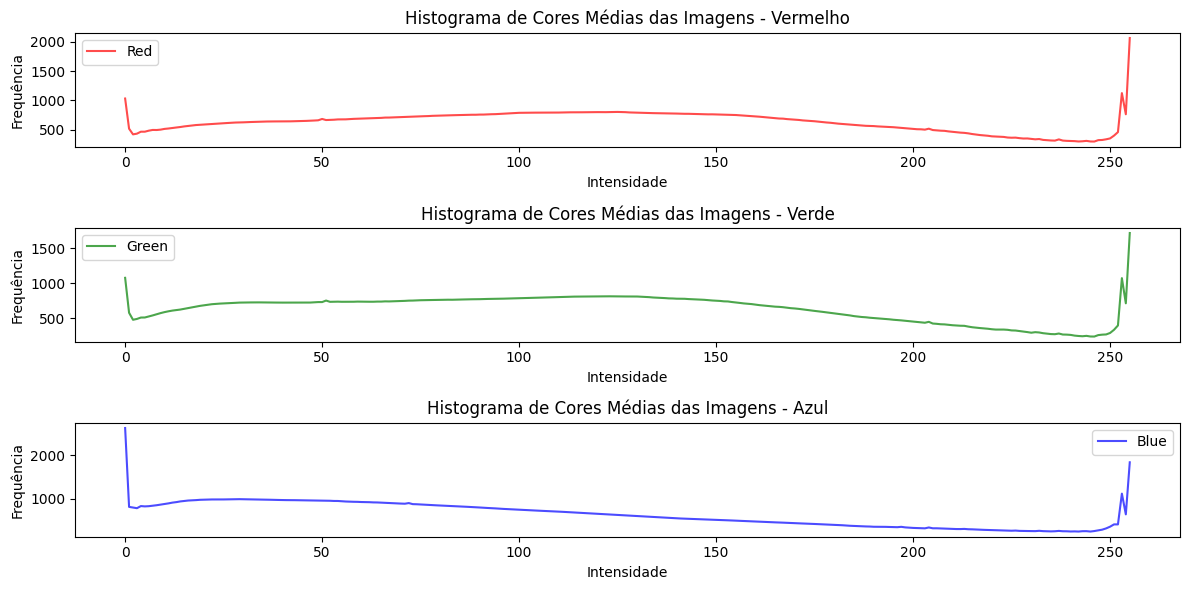

In [121]:
# Histograma de cores RGB

# Função para calcular os histogramas de cores de uma imagem
def calculate_color_histogram(image):
    hist_r = np.histogram(image[:,:,0], bins=256, range=(0, 256))
    hist_g = np.histogram(image[:,:,1], bins=256, range=(0, 256))
    hist_b = np.histogram(image[:,:,2], bins=256, range=(0, 256))
    return hist_r, hist_g, hist_b

# Calcular os histogramas de cores para todas as imagens
histograms_r, histograms_g, histograms_b = [], [], []
for img in images:
    hist_r, hist_g, hist_b = calculate_color_histogram(img)
    histograms_r.append(hist_r[0])
    histograms_g.append(hist_g[0])
    histograms_b.append(hist_b[0])

# Calcular a média dos histogramas
mean_hist_r = np.mean(histograms_r, axis=0)
mean_hist_g = np.mean(histograms_g, axis=0)
mean_hist_b = np.mean(histograms_b, axis=0)

# Plotar os histogramas de cores médias
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(mean_hist_r, color='red', label='Red', alpha=0.7)
plt.title('Histograma de Cores Médias das Imagens - Vermelho')
plt.xlabel('Intensidade')
plt.ylabel('Frequência')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(mean_hist_g, color='green', label='Green', alpha=0.7)
plt.title('Histograma de Cores Médias das Imagens - Verde')
plt.xlabel('Intensidade')
plt.ylabel('Frequência')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(mean_hist_b, color='blue', label='Blue', alpha=0.7)
plt.title('Histograma de Cores Médias das Imagens - Azul')
plt.xlabel('Intensidade')
plt.ylabel('Frequência')
plt.legend()

plt.tight_layout()
plt.show()

A partir do gráfico de barras é possível inferir que a maioria das imagens possuem um achatamento na largura maior que altura, o que, consequentemente, resulta em imagens em sua maioria um retângulo e não um quadrado perfeito.

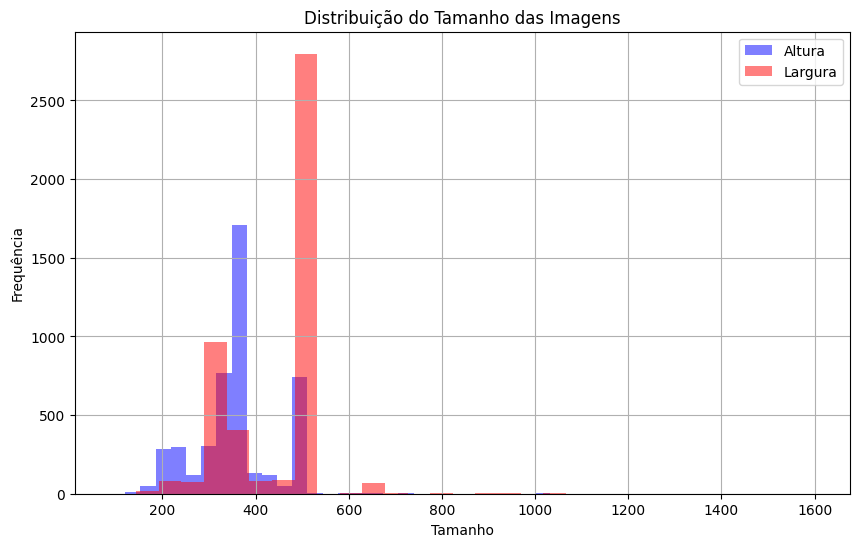

In [122]:
# Distribuição do tamanho das imagens

# Calcular as dimensões das imagens
dimensions = [(img.shape[0], img.shape[1]) for img in images]

# Extrair altura e largura das imagens
heights = [dim[0] for dim in dimensions]
widths = [dim[1] for dim in dimensions]

# Plotar histograma de distribuição do tamanho das imagens
plt.figure(figsize=(10, 6))
plt.hist(heights, bins=30, alpha=0.5, color='b', label='Altura')
plt.hist(widths, bins=30, alpha=0.5, color='r', label='Largura')
plt.title('Distribuição do Tamanho das Imagens')
plt.xlabel('Tamanho')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True)
plt.show()

Diante do gráfico, é possível inferir que a distribuição do brilho se assemelha a uma distribuição normal, mantendo a maioria das imagens na frequência entre [100, 150]

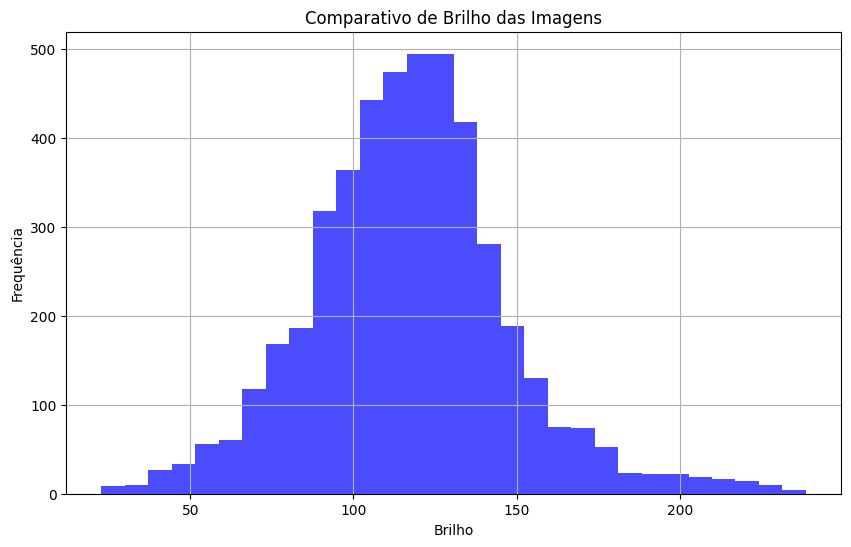

In [313]:
# Função para calcular a média da intensidade dos pixels de uma imagem
def calculate_brightness(image):
    # Converter a imagem para tons de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calcular a média da intensidade dos pixels
    brightness = np.mean(gray)
    return brightness

# Calcular a média da intensidade dos pixels para todas as imagens
brightness_values = [calculate_brightness(img) for img in images]

# Plotar o comparativo de brilho das imagens
plt.figure(figsize=(10, 6))
plt.hist(brightness_values, bins=30, color='blue', alpha=0.7)
plt.title('Comparativo de Brilho das Imagens')
plt.xlabel('Brilho')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

Com a distribuição dos keypoints é possível inferir um alto grau de confiança com os keypoints na faixa de [12, 17], sendo estes concentrados na parte superior dos animais.

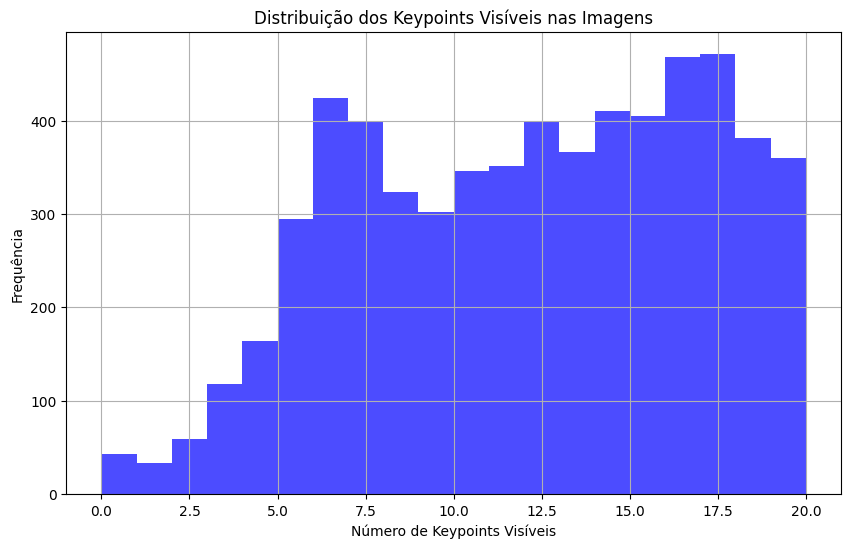

In [124]:
# Função para contar o número de keypoints visíveis em uma imagem
def count_visible_keypoints(annotations_dataframe):
    visible_keypoints = []
    for index, row in annotations_dataframe.iterrows():
        keypoints = row['keypoints']
        num_visible_keypoints = sum(1 for keypoint in keypoints if keypoint[2] > 0)  # Contagem dos keypoints visíveis
        visible_keypoints.append(num_visible_keypoints)
    return visible_keypoints

# Contar o número de keypoints visíveis em cada imagem
visible_keypoints = count_visible_keypoints(annotations_dataframe)

# Plotar o histograma da distribuição dos keypoints visíveis
plt.figure(figsize=(10, 6))
plt.hist(visible_keypoints, bins=20, color='blue', alpha=0.7)
plt.title('Distribuição dos Keypoints Visíveis nas Imagens')
plt.xlabel('Número de Keypoints Visíveis')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

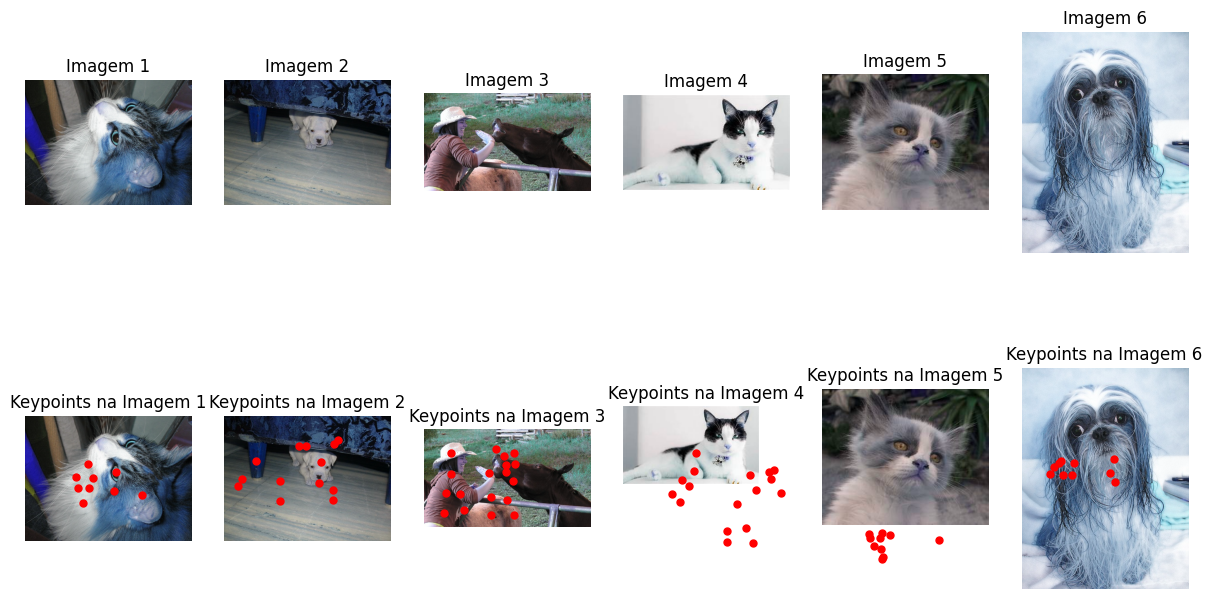

In [125]:
# Função para exibir as imagens com os keypoints visíveis
def display_images_with_keypoints(images, annotations_dataframe, num_images=6):
    plt.figure(figsize=(15, 8))
    for i in range(num_images):
        # Carregar a imagem
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

        # Extrair keypoints da imagem i
        keypoints = annotations_dataframe.loc[i, 'keypoints']

        plt.subplot(2, num_images, i + 1)
        plt.imshow(image)
        plt.title('Imagem {}'.format(i+1))
        plt.axis('off')

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(image)
        for point in keypoints:
            if point[2] > 0:  # Verificar se o keypoint é visível
                plt.plot(point[0], point[1], 'ro', markersize=5)  # Plotar keypoints
        plt.title('Keypoints na Imagem {}'.format(i+1))
        plt.axis('off')
    plt.show()

# Exibir algumas imagens com os keypoints visíveis
display_images_with_keypoints(images, annotations_dataframe, num_images=6)

In [208]:
unique_image_ids = annotations_dataframe['image_id'].unique()

# Filtrar as linhas correspondentes aos image_id únicos
unique_image_rows = annotations_dataframe[annotations_dataframe['image_id'].isin(unique_image_ids)]

Distribuição das 5 categorias diante do dataset de mais de 4000 imagens e mais de 6000 instâncias. É possível inferir que o conjunto de imagens com categoria "vaca" é a menor do dataset, valor de "842", porém é importante ficar atento, pois, posteriormente haverá uma limpeza nos dados de modo a tirar ruídos.

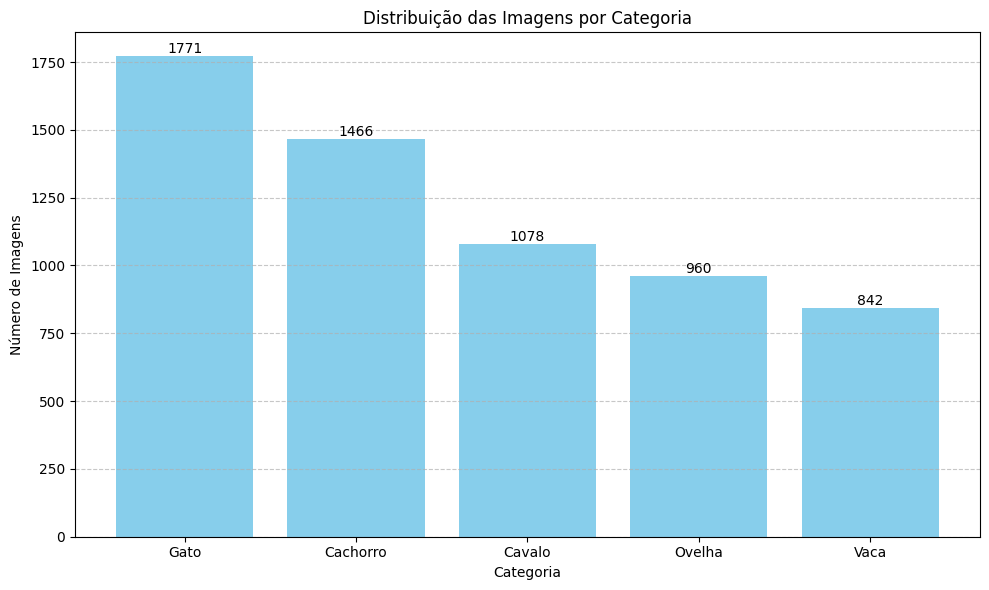

In [126]:
# Mapeamento das categorias
category_names = {
    1: 'Gato',
    2: 'Cachorro',
    3: 'Cavalo',
    4: 'Ovelha',
    5: 'Vaca'
}

# Contagem do número de imagens em cada categoria
category_counts = annotations_dataframe['category_id'].map(category_names).value_counts()

# Plotar o gráfico de barras da distribuição das imagens por categoria
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts, color='skyblue')

plt.title('Distribuição das Imagens por Categoria')
plt.xlabel('Categoria')
plt.ylabel('Número de Imagens')

# Ajustar a posição das etiquetas no eixo x
plt.xticks(rotation=0, ha='center')

# Adicionar os valores de cada barra acima das barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Separação do Conjunto da Categoria Bovinos

Primeiramente começa separando linhas do dataframe que são de categoria 5 (vaca)

In [225]:
def select_cow_annotations(annotations_dataframe):
    cow_annotations = annotations_dataframe.loc[annotations_dataframe['category_id'] == 5]
    return cow_annotations

# Selecionar apenas as linhas com category_id igual a 5 (vaca)
cow_annotations = select_cow_annotations(annotations_dataframe)

Existe 842 bovinos antes da limpeza dos ruídos

In [328]:
# Quantidade de bovinos antes do processamento de limpeza de ruídos nos dados
cow_annotations.shape

(842, 5)

In [232]:
# Obter os image_id únicos do DataFrame
unique_image_ids = cow_annotations['image_id'].unique()

# Filtrar as linhas correspondentes aos image_id únicos
unique_image_rows = cow_annotations.drop_duplicates(subset=['image_id'])

In [243]:
# Pegar os image_ids únicos do DataFrame unique_image_rows
unique_image_ids = unique_image_rows['image_id']

In [256]:
# Filtrar os elementos em keypoints["images"] com base nos image_ids únicos
filtered_keypoints = []
for img_id, img_data in keypoints["images"].items():
    img_id = int(img_id)
    if img_id in unique_image_ids.values:
        filtered_keypoints.append(img_data)

In [261]:
# Função para carregar todas as imagens correspondentes aos keypoints filtrados
def load_filtered_images(images_path, filtered_keypoints):
    images, image_files = [], []
    for img_data in filtered_keypoints:
        img_path = os.path.join(images_path, img_data)
        if os.path.isfile(img_path):
            image = Image.open(img_path).convert('RGB')
            images.append(np.array(image))
            image_files.append(img_data)
    return images, image_files

# Carregar apenas as imagens correspondentes aos keypoints filtrados
filtered_images, filtered_image_files = load_filtered_images(images_path, filtered_keypoints)

Importante citar que antes da limpeza de ruídos nos dados o dataset tinha 842 imagens de bovinos, e pós limpeza contém 534

In [332]:
# Quantidade de bovinos oficiais no dataset pós limpeza de ruídos nos dados
# Ou seja o dataset contém 534 imagens de bovinos
len(filtered_images)

534

# Processamento de Filtros Aplicados

Diferentes filtros e técnicas de pré-processamento de imagens aplicados a um conjunto de imagens usando a biblioteca Pillow no Python. Vamos passar pelas etapas de aplicação de filtros para redução de ruído, melhoria de nitidez, suavização e ajuste de contraste.

1. Filtros Utilizados:
- Filtro Gaussiano: Reduz o ruído da imagem aplicando um desfoque gaussiano.
- Filtro de Nitidez: Aumenta a nitidez da imagem realçando as bordas.
- Filtro de Mediana: Reduz o ruído impulsivo (ou "sal e pimenta") na imagem.
- Ajuste de Contraste: Aumenta o contraste da imagem, tornando as diferenças entre os tons mais distintas.

2. Passo a Passo do Pré-Processamento:

- Carregamento da Imagem Original:

A primeira imagem é carregada para visualização.
- Filtro Gaussiano:

Aplica-se o filtro gaussiano para redução de ruído.
Exibe-se a imagem resultante após a aplicação do filtro.
- Filtro de Nitidez:

Aplica-se o filtro de nitidez para melhorar a definição de bordas.
Exibe-se a imagem resultante após a aplicação do filtro.
- Filtro de Mediana:

Aplica-se o filtro de mediana para reduzir o ruído impulsivo.
Exibe-se a imagem resultante após a aplicação do filtro.
- Ajuste de Contraste:

Realiza-se o ajuste de contraste na imagem para aumentar a diferença entre os tons. Exibe-se a imagem resultante após o ajuste de contraste.


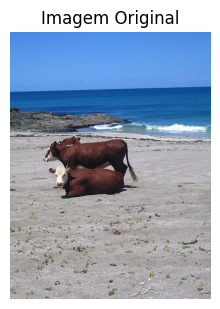

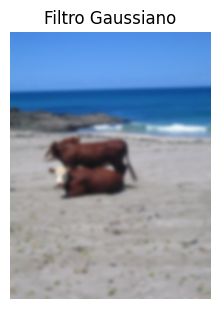

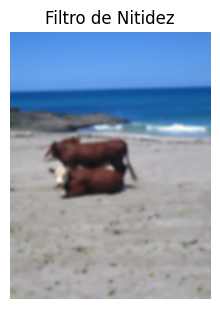

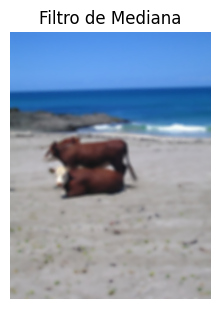

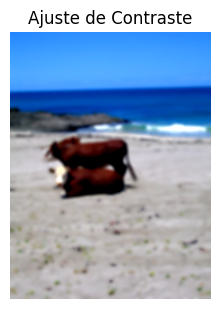

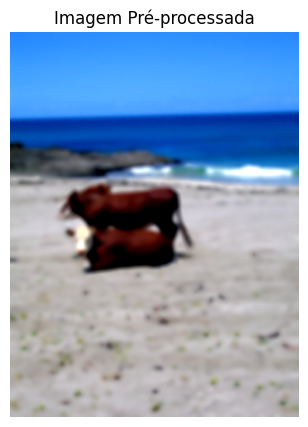

In [294]:
def preprocess_images(images):
    preprocessed_images = []
    for idx, img in enumerate(images):
        # Converter a imagem numpy.ndarray em um objeto Image
        pil_image = Image.fromarray(img)

        if idx == 0:
            # Exibir a imagem original
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 5, 1)
            plt.imshow(pil_image)
            plt.title('Imagem Original')
            plt.axis('off')
            plt.show()

        # Aplicar filtros de pré-processamento
        filtered_image = pil_image.filter(ImageFilter.GaussianBlur(3))  # Filtro Gaussiano para redução de ruído
        if idx == 0:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 5, 2)
            plt.imshow(filtered_image)
            plt.title('Filtro Gaussiano')
            plt.axis('off')
            plt.show()

        filtered_image = filtered_image.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))  # Filtro de Nitidez
        if idx == 0:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 5, 3)
            plt.imshow(filtered_image)
            plt.title('Filtro de Nitidez')
            plt.axis('off')
            plt.show()

        filtered_image = filtered_image.filter(ImageFilter.MedianFilter(size=3))  # Filtro de Mediana para redução de ruído impulsivo
        if idx == 0:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 5, 4)
            plt.imshow(filtered_image)
            plt.title('Filtro de Mediana')
            plt.axis('off')
            plt.show()

        # Ajustar o contraste
        enhancer = ImageEnhance.Contrast(filtered_image)
        filtered_image = enhancer.enhance(1.5)  # Aumentar o contraste em 50%
        if idx == 0:
            plt.figure(figsize=(15, 5))
            plt.subplot(1, 5, 5)
            plt.imshow(filtered_image)
            plt.title('Ajuste de Contraste')
            plt.axis('off')
            plt.show()

        preprocessed_images.append(filtered_image)

    return preprocessed_images

# Aplicar os filtros de pré-processamento a todas as imagens
preprocessed_images = preprocess_images(filtered_images)

# Exibir a primeira imagem pré-processada
plt.figure(figsize=(10, 5))
plt.imshow(preprocessed_images[0])
plt.title('Imagem Pré-processada')
plt.axis('off')
plt.show()

# Fluxo do Processamento em Diagrama

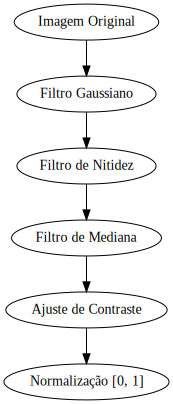

In [295]:
# Definindo o gráfico
dot = Digraph()

# Adicionando os nós e as conexões
dot.node('A', 'Imagem Original')  # Nó A: Representa a imagem original
dot.node('B', 'Filtro Gaussiano')  # Nó B: Representa a aplicação do Filtro Gaussiano
dot.node('C', 'Filtro de Nitidez')  # Nó C: Representa a aplicação do Filtro de Nitidez
dot.node('D', 'Filtro de Mediana')  # Nó D: Representa a aplicação do Filtro de Mediana
dot.node('E', 'Ajuste de Contraste')  # Nó E: Representa o Ajuste de Contraste
dot.node('F', 'Normalização [0, 1]')  # Nó F: Representa a Normalização para o intervalo [0, 1]

dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])  # Define as conexões entre os nós

# Definindo as configurações do gráfico
dot.attr(rankdir='TB', size='20')

# Salvando o gráfico como uma imagem
dot.render('preprocessing_flowchart', format='png', cleanup=True)

# Exibindo o gráfico
dot

# Visualização Gráfica dos Resultados

A distribuição de brilho continou quase como uma distribuição normal dentre todos os canais, demonstrando que sua intensidade não se afetou após os filtros aplicados.

[[123.56760533 148.20468267 180.31097067]
 [109.71760479 101.19696407  87.62962275]
 [151.36680097 143.90813592 141.06682039]
 ...
 [123.33751667 138.08701667 104.33586667]
 [144.07853107 141.26301318 123.44542373]
 [153.3231     181.50973333 176.40908889]]


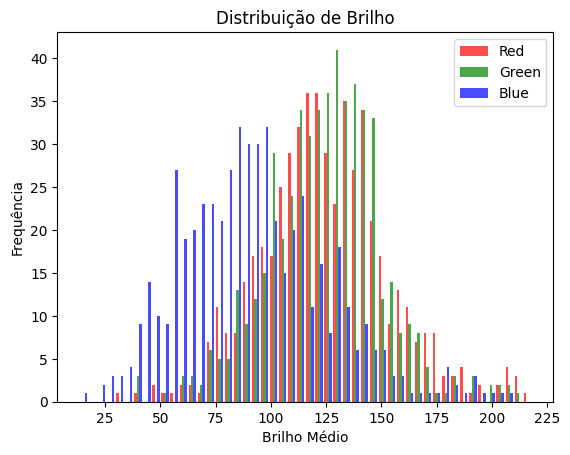

In [325]:
# Função para calcular a média dos pixels de cada imagem
def calculate_brightness(images):
    brightness = [np.mean(np.mean(np.array(img), axis=0), axis=0) for img in images]
    return np.array(brightness)

def plot_brightness_distribution(brightness_distribution):
    plt.hist(brightness_distribution, bins=50, color=['red', 'green', 'blue'], alpha=0.7, label=['Red', 'Green', 'Blue'])
    plt.title('Distribuição de Brilho')
    plt.xlabel('Brilho Médio')
    plt.ylabel('Frequência')
    plt.legend()
    plt.show()

# Calcular a média dos pixels de cada imagem
brightness_distribution = calculate_brightness(preprocessed_images)
print(brightness_distribution)
plot_brightness_distribution(brightness_distribution)

A distribuição de cores saiu das pontas a concentração e ficou concentrada no meio, aparentemente causando uma distribuição mais equilibrada

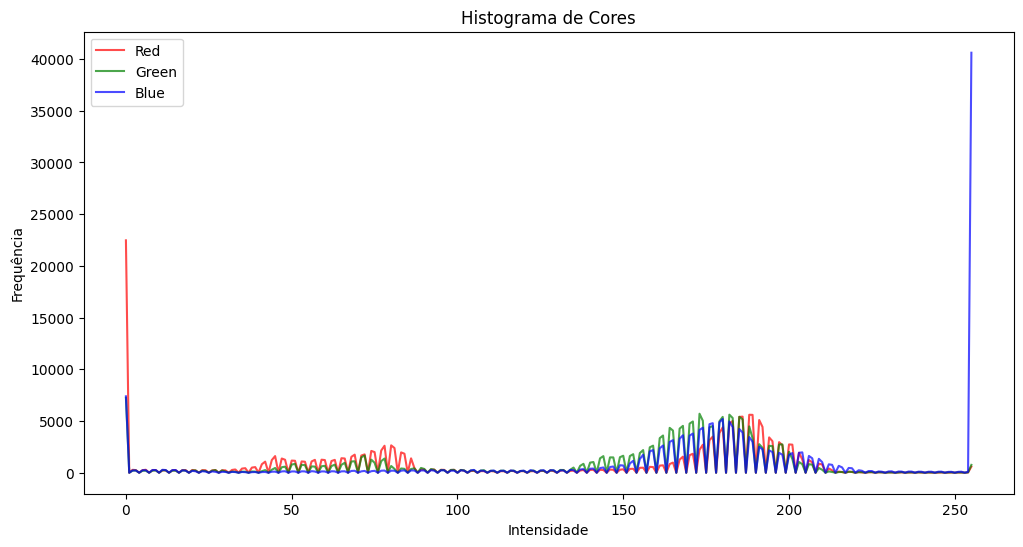

In [326]:
# Função para calcular o histograma de cores para uma imagem
def calculate_color_histogram(image):
    hist_r = np.histogram(np.array(image)[:,:,0], bins=256, range=(0, 256))
    hist_g = np.histogram(np.array(image)[:,:,1], bins=256, range=(0, 256))
    hist_b = np.histogram(np.array(image)[:,:,2], bins=256, range=(0, 256))
    return hist_r, hist_g, hist_b

# Calcular o histograma de cores para uma imagem
image_index = 0  # Selecionar a primeira imagem para o exemplo
hist_r, hist_g, hist_b = calculate_color_histogram(preprocessed_images[image_index])

# Plotar o histograma de cores
plt.figure(figsize=(12, 6))
plt.plot(hist_r[0], color='red', label='Red', alpha=0.7)
plt.plot(hist_g[0], color='green', label='Green', alpha=0.7)
plt.plot(hist_b[0], color='blue', label='Blue', alpha=0.7)
plt.title('Histograma de Cores')
plt.xlabel('Intensidade')
plt.ylabel('Frequência')
plt.legend()
plt.show()